# Goal

Analyse the sctruture of adjacency matrices and their metrics over time and by congress


## Main Takeaways
- The congress 111 is the most sparse one and with strong separation between republicans and democrats (we see it by averaging the adjacency matrics and through metrics of density and centrality)
- For most of congresses, the the averaged adjacency matrix loses its shape on the last semester of the first year and returns to the behavior in the coming semester. However the same behavior can not be seen in the last semester of de congress (last semester of the second year). The number of laws proposed in the last semester of first year is lower as well as we saw in `analysis-historical-votes.ipynb`
- Our hypothesis that the senators from democrats and republicans change their behavior by the end of the period does not hold if we analyse the averaged adjacency matrices for all congresses. On the other had, it is possible see that the connected components increases quite consistenly during the period


## Further Analysis

The analysis of adjacency matrices and votes by subject and party that proposed it is available in `analysis-historical-by-subject.ipynb`


In [2]:
import os
import pandas as pd
import numpy as np

import pickle
import networkx as nx

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
ALL_LAWS_PATH = '../data/all-votes/laws_20years.csv'
ALL_ADJACENCY_PATH = '../data/all-votes/all_adjacency.pickle'
pal = {'republican': '#ff0000', 'democrats': '#0000ff'}
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=2, color_codes=True, rc=None)

In [4]:
all_laws = pd.read_csv(ALL_LAWS_PATH)
all_laws['law_id'] = all_laws['vote_uri'].apply(lambda x: '_'.join(x.split('/')[4:]).split('.')[0])
all_laws['q'] = pd.to_datetime(all_laws.date).dt.quarter
all_laws['quarter'] = all_laws.apply(lambda x: '1' '-' + str(x['q']) if x['year'] % 2==0 else '2' + '-' + str(x['q']), axis=1)
print(all_laws.shape)

with open(ALL_ADJACENCY_PATH, 'rb') as handle:
    adjacencies = pickle.load(handle)
print(len(adjacencies))

(6834, 20)
6834


In [5]:
def get_metrics(a):
    m = {}
    
    m['shape'] = a.shape
    m['L'] = a.sum(axis=1).sum(axis=0)
#     m['degree'] = a.sum(axis=1)

    G = nx.Graph(a)
    eigenvalues = nx.laplacian_spectrum(G)
    m['eigenvalues'] = eigenvalues
    m['degree_centality'] = nx.degree_centrality(G)
    m['connected_components'] = len(list(nx.connected_component_subgraphs(G)))
    m['density'] = nx.density(G)
    
    return m

In [6]:
all_metrics = [(k, get_metrics(v)) for k, v in adjacencies.items()]

In [7]:
df_metrics = pd.DataFrame([x[1] for x in all_metrics])
df_metrics['law_id'] = [x[0] for x in all_metrics]
df_metrics = df_metrics.merge(all_laws)

In [8]:
pd.DataFrame(df_metrics.iloc[0].T)

,0
L,8932
connected_components,5
degree_centality,"{0: 0.9494949494949496, 1: 0.9494949494949496,..."
density,0.902222
eigenvalues,"[-4.263256414560601e-14, -3.552713678800501e-1..."
shape,"(100, 100)"
law_id,v1_105_senate_sessions_1_votes_4
bill_api_uri,NaN
congress,105
date,1997-01-30


In [9]:
df_metrics.to_csv('../data/all-votes/all_adjacency_metric.csv', index=False)

### Heatmap of adjacency matricies over time by congress
ps: matrices are ordered by Democrats -> Indepedent -> Republicans

In [33]:
6%5

1

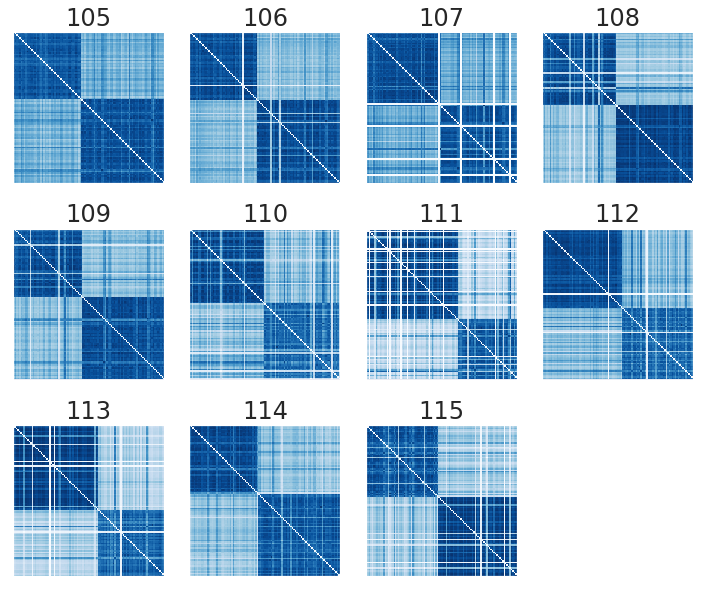

In [135]:
by = 'quarter'
quarters = sorted(all_laws[by].unique())
congress = all_laws['congress'].unique()

f, ax = plt.subplots(3, 4, figsize=(20, 10), squeeze=True )
for i, c in enumerate(congress):
    
    laws = list(all_laws[(all_laws.congress == c)]['law_id'])
    n = len(laws)
    sum_adjacencies = adjacencies[laws[0]]
    for l in laws[1:]:
        sum_adjacencies += adjacencies[l]

    sum_adjacencies /= n
#     sum_adjacencies = 1 - sum_adjacencies # xunxo to get right color pattern

    ax[i//4, i%4].set_title('{}'.format(c))
    ax[i//4, i%4].imshow(sum_adjacencies, cmap = 'Blues')
    ax[i//4, i%4].set_xticks([])
    ax[i//4, i%4].set_yticks([])
f.delaxes(ax[2,3])
plt.subplots_adjust(wspace=-.7, hspace=0.3)
plt.savefig('figs/adj_matrix.pdf', bbox_inches='tight')

### General overview of metrics of adjacency matrices by congress

In [145]:
df_metrics['avg_degree_centrality'] = df_metrics['degree_centality'].apply(lambda x: np.mean(list(x.values())))

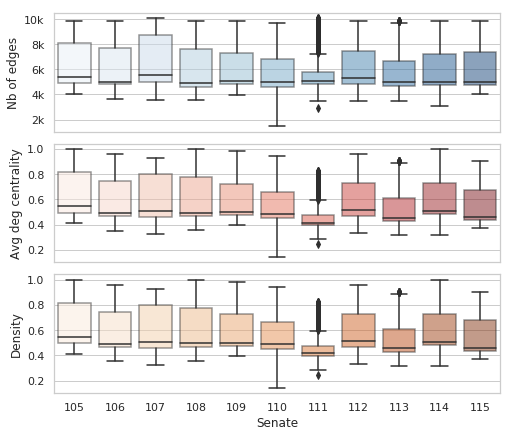

In [193]:
sns.set(style="whitegrid")
f, ax = plt.subplots(3,1, figsize=(8,7))
sns.boxplot(x='congress', y='L', data=df_metrics, boxprops=dict(alpha=.5), ax = ax[0], palette = sns.color_palette("Blues", 11))
sns.boxplot(x='congress', y='avg_degree_centrality', data=df_metrics, boxprops=dict(alpha=.5), ax = ax[1], palette = sns.color_palette("Reds", 11))
sns.boxplot(x='congress', y='density', data=df_metrics, ax = ax[2], boxprops=dict(alpha=.5), palette = sns.color_palette("Oranges", 11))

ax[0].set_xticks([])
ax[0].set_xlabel(None)
ax[1].set_xticks([])
ax[1].set_xlabel(None)
ax[2].set_xlabel('Senate')
ax[0].set_ylabel('Nb of edges')
ax[1].set_ylabel('Avg deg centrality')
ax[2].set_ylabel('Density')
ax[0].set_yticklabels(['', '2k', '4k', '6k', '8k', '10k'])
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig('figs/graph_stats.pdf', bbox_inches='tight')

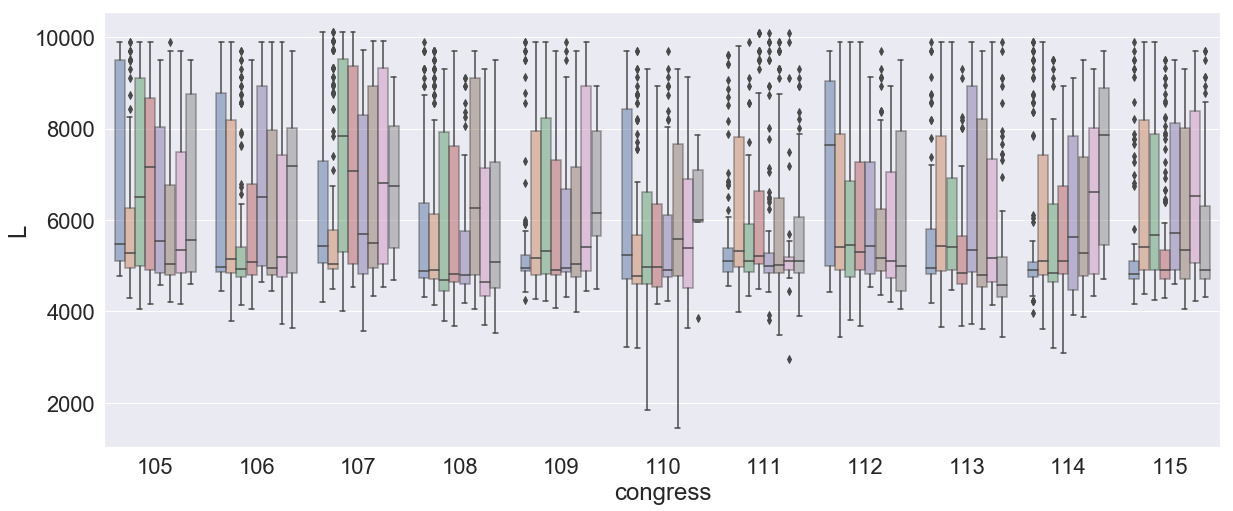

In [309]:
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='congress', y='L', hue='quarter', data=df_metrics, boxprops=dict(alpha=.5))
ax.legend_.remove()

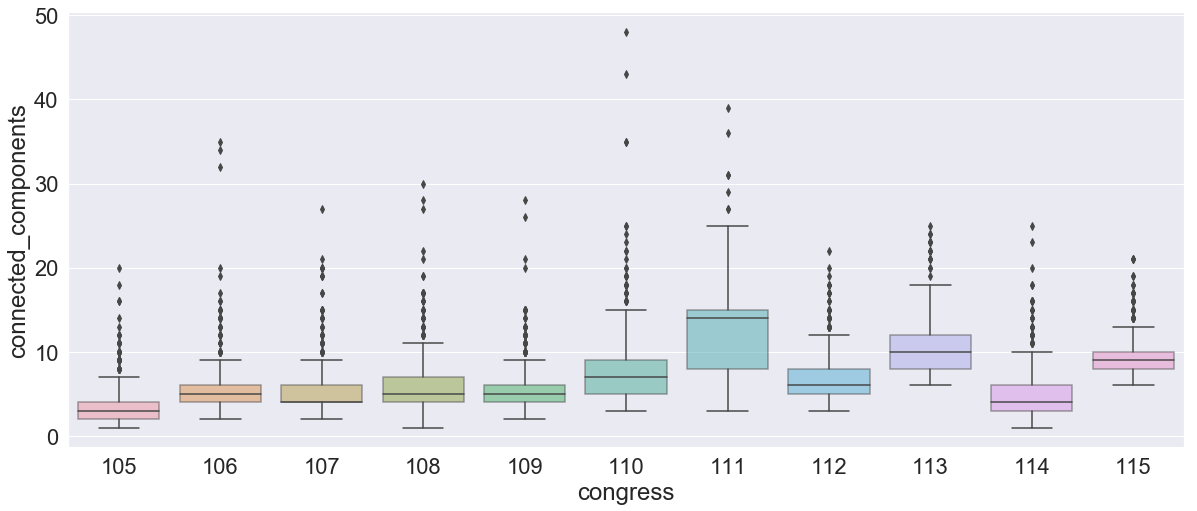

In [303]:
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='congress', y='connected_components', data=df_metrics, boxprops=dict(alpha=.5))

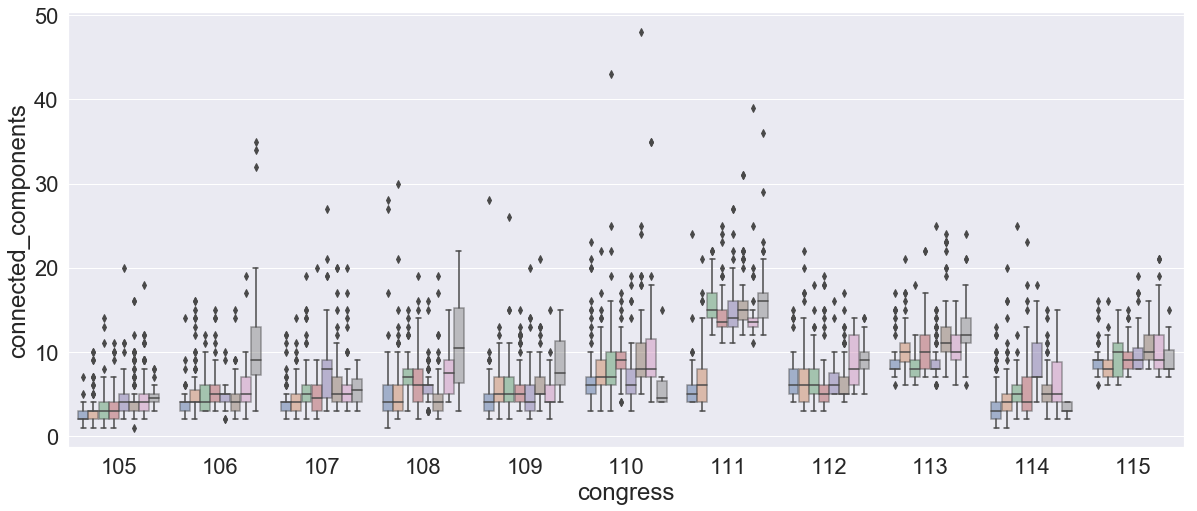

In [307]:
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='congress', y='connected_components', hue='quarter', data=df_metrics, boxprops=dict(alpha=.5))
ax.legend_.remove()

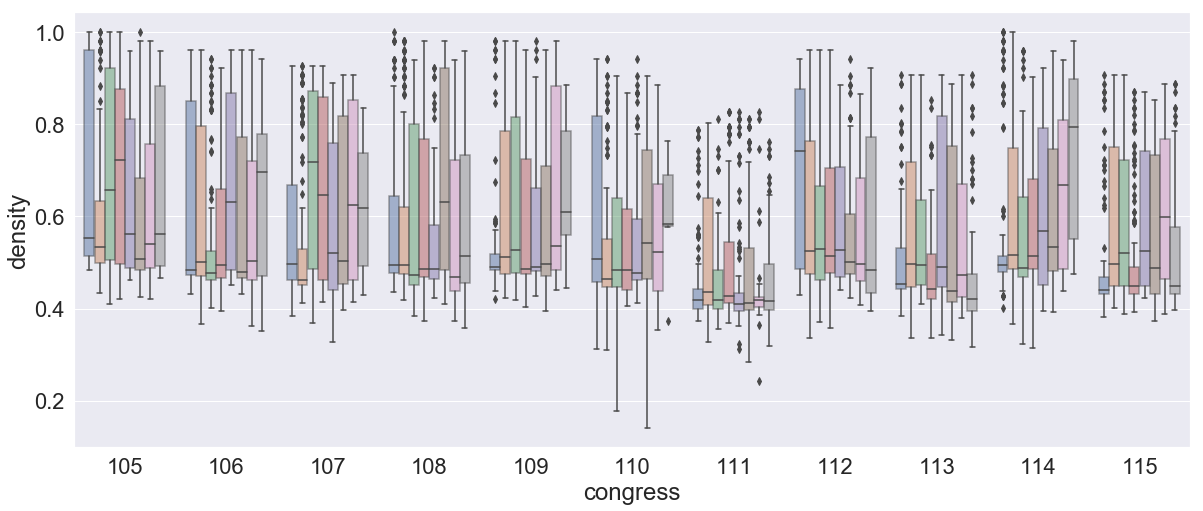

In [310]:
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='congress', y='density', hue='quarter', data=df_metrics, boxprops=dict(alpha=.5))
ax.legend_.remove()

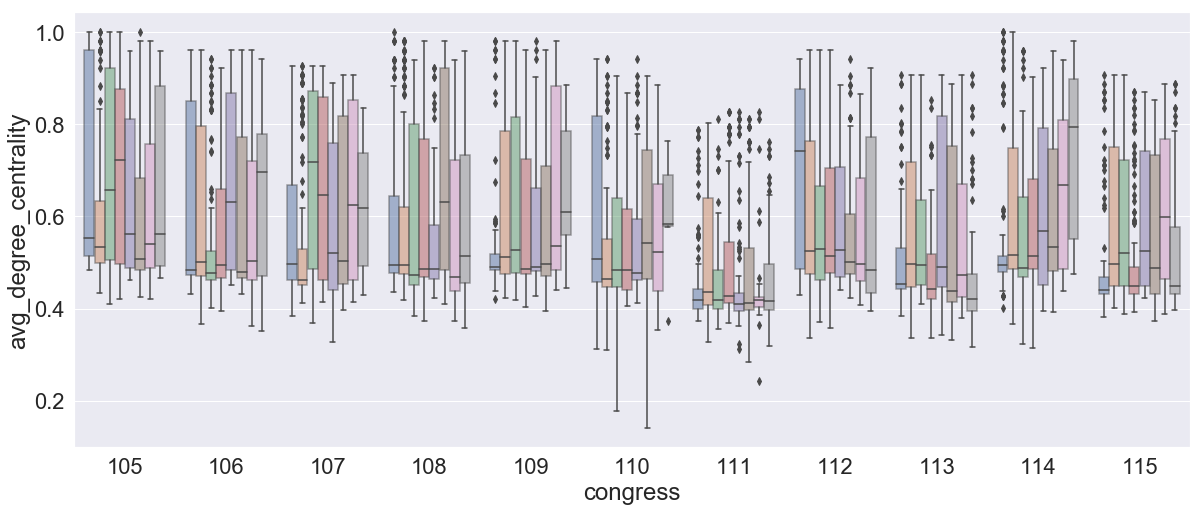

In [311]:
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='congress', y='avg_degree_centrality', hue='quarter', data=df_metrics, boxprops=dict(alpha=.5))
ax.legend_.remove()

In [312]:
range_evals = 10
for i in range(0, range_evals):
    name = '{}_evalue'.format(i + 1)
    df_metrics[name] = df_metrics['eigenvalues'].apply(lambda x: x[i])
(df_metrics[['{}_evalue'.format(i + 1) for i in range(0, range_evals)]]
 .describe()
 .T[['mean', 'min', '25%', '50%', '75%', 'max']]
 .applymap(lambda x: round(x, 2)))

,mean,min,25%,50%,75%,max
1_evalue,-0.00,-0.0,-0.0,-0.0,-0.0,0.0
2_evalue,0.22,-0.0,-0.0,-0.0,-0.0,100.0
3_evalue,2.46,-0.0,-0.0,-0.0,0.0,100.0
4_evalue,6.06,-0.0,-0.0,0.0,0.0,100.0
5_evalue,10.89,-0.0,-0.0,0.0,4.0,100.0
6_evalue,15.84,-0.0,0.0,0.0,32.0,101.0
7_evalue,20.68,-0.0,0.0,3.0,41.0,101.0
8_evalue,25.71,-0.0,0.0,12.0,44.0,101.0
9_evalue,30.27,-0.0,0.0,29.0,45.0,101.0
10_evalue,34.37,-0.0,3.0,36.0,46.0,101.0


> Some congress have 102 members